In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import d1_riskkit_3101 as d1
from pypfopt import risk_models
from pypfopt import expected_returns

from datetime import datetime
%matplotlib inline

# Importering og filtrering af data

 ### Data for aktier og obligationer

In [2]:
d1_data = pd.read_excel("Data/bondsandstocks_data.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [3]:
d1_data = d1_data['1973-01-31':'2020-12-31']

In [4]:
# Her sættes værdi lig sidste business dag i måneden
mnd_data = d1_data.resample('BMS').last()

In [5]:
mnd_afkast = np.log(mnd_data/mnd_data.shift(1)).dropna()

In [6]:
# Her ændres datoformat til år og måned
mnd_afkast.index = mnd_afkast.index.to_period('M')

In [7]:
# Her navngives kolonner
mnd_afkast.columns = ['Obligationer', 'Aktier']

## Renter

### Risikofri rente 

In [8]:
rf_data= pd.read_excel("Data/risikofri_rente.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [9]:
rf_år = rf_data['1973-01-31':'2020-12-31']/100

In [10]:
rf_måned = (1+rf_år)**(1/12)-1

In [11]:
# Her sættes værdi lig sidste business dag i måneden
mnd_rf = rf_måned.resample('BMS').last()

In [12]:
# Her ændres datoformat til år og måned
mnd_rf.index = mnd_rf.index.to_period('M')

In [72]:
# Her navngives kolonner
mnd_rf.columns = ['Risikofri Rente']
mnd_rf = mnd_rf['1973-02':]

### Lånerente

In [14]:
r_lån_data= pd.read_excel("Data/fed_funds.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [15]:
r_lån_år = r_lån_data['1973-01-31':'2020-12-31']/100

In [16]:
r_lån_mnd = (1+r_lån_år)**(1/12)-1

In [17]:
# Her sættes værdi lig sidste business dag i måneden
mnd_lån = r_lån_mnd.resample('BMS').last()

In [18]:
# Her ændres datoformat til år og måned
mnd_lån.index = mnd_lån.index.to_period('M')

In [19]:
# Her navngives kolonner
mnd_lån.columns = ['Lånerente']
mnd_lån = mnd_lån['1973-02':]

## Graf over udvikling i renteniveauer 1973-2020

<AxesSubplot:title={'center':'Udvikling i renteniveauer 1973-2020'}, xlabel='Date'>

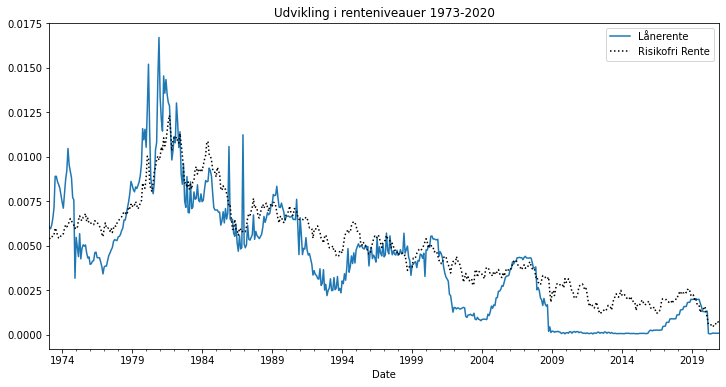

In [20]:
akse = mnd_lån.plot(figsize=(12,6), title = 'Udvikling i renteniveauer 1973-2020')
mnd_rf.plot(ax=akse, style="k:")

# Graf og statistik over prisudvikling over tid for aktier og obligationer


<AxesSubplot:title={'center':'Prisudvikling over tid for aktier og obligationer 1973-2020'}, xlabel='Date'>

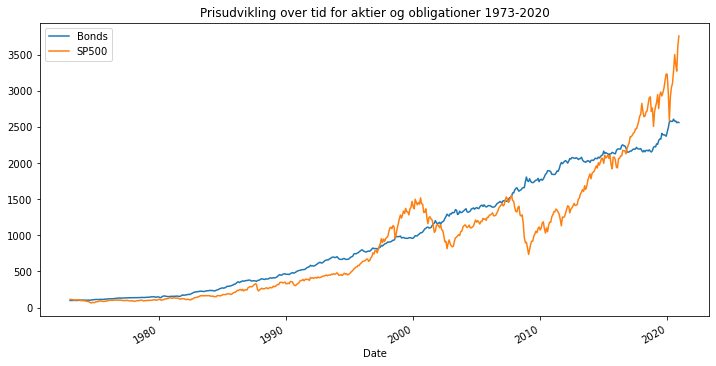

In [21]:
mnd_data.plot(figsize = (12,6), title = 'Prisudvikling over tid for aktier og obligationer 1973-2020')

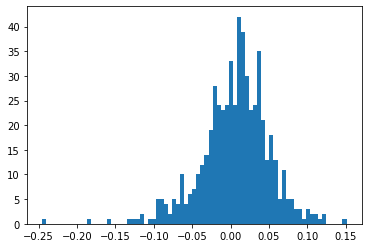

In [75]:
plt.hist(mnd_afkast['Aktier'].dropna(), bins=75, density=False)
plt.show()

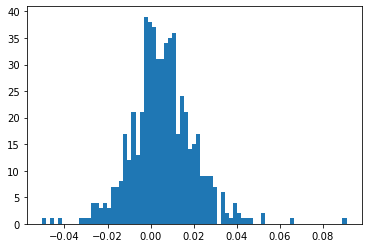

In [23]:
plt.hist(mnd_afkast['Obligationer'].dropna(), bins=75, density=False)
plt.show()

In [24]:
risikofri_rente = np.array(mnd_rf)

In [25]:
# Statistik på et aggregeret niveau for perioden 1973 - 2020
akt_obl_stats = d1.stats(mnd_afkast, riskfree_rate=risikofri_rente)
akt_obl_stats

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Obligationer,0.068676,0.050757,0.137898,-0.076841
Aktier,0.062073,0.154740,0.003979,-0.568764


# Konstruering af porteføljer

## Aktie portefølje bestående af S&P500

In [26]:
pf_aktie = pd.DataFrame({'Aktier': mnd_afkast['Aktier']})

## Traditionel 60/40 portefølje

In [27]:
# Her antages det at der rebalanceres månedligt
pf_6040 = 0.6*mnd_afkast['Aktier'] + 0.4*mnd_afkast['Obligationer']

In [28]:
pf_6040 = pd.DataFrame({'60/40 portefølje': pf_6040})

## Risk Parity Ugearet - skal opdateres

In [29]:
w_rp_ug = d1.optimale_rp_vægte(mnd_afkast)

optimale_rul_rp_vægte = pd.DataFrame().reindex_like(mnd_afkast)
optimale_rul_rp_vægte.columns = ['Vægt obl.', 'Vægt akt.']
optimale_rul_rp_vægte

In [30]:
# Her afgrænses test perioden, således at den ikke inkluderer estimationsperioden
afkast_aktiver = mnd_afkast['1978-02':'2020-12']

In [31]:
afkast_rp_ug = w_rp_ug.iloc[:,0] * afkast_aktiver.iloc[:,0]+w_rp_ug.iloc[:,1] * afkast_aktiver.iloc[:,1]
afkast_rp_ug = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_rp_ug})

## Risk Parity Gearet - skal opdateres

$$ w_{a} * R_{p} + (1 - w_{a}) * r_{borrowing} $$

In [33]:
# Her samles RP ugearet og lånerente i en DataFrame
rp_aktiver = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_rp_ug['Risk Parity Ugearet afkast'], 'Lånerente': mnd_lån['1978-02':'2020-12']['Lånerente']})

In [34]:
w_rp_g = d1.target_risk(rp_aktiver, 0.1)

In [35]:
afkast_rp_g = w_rp_g.iloc[:,0] * rp_aktiver['1983-02':'2020-12'].iloc[:,0]+w_rp_g.iloc[:,1] * rp_aktiver['1983-02':'2020-12'].iloc[:,1]
afkast_rp_g = pd.DataFrame({'Risk Parity Gearet afkast': afkast_rp_g})

# Afgrænsning til testperiode

In [36]:
# Aktier
pf_aktie = pf_aktie['1983-02':'2020-12']

In [37]:
# 60/40
pf_6040 = pf_6040['1983-02':'2020-12']

In [38]:
# Risk Parity ugearet
pf_rp_u = afkast_rp_ug['1983-02':'2020-12']

In [39]:
# Risk Parity gearet
pf_rp_g = afkast_rp_g

# Wealth Index

In [40]:
pf_afkast = pd.DataFrame({'Aktie portefølje': pf_aktie['Aktier'], '60/40 portefølje': pf_6040['60/40 portefølje'], 'Risk Parity Ugearet': pf_rp_u['Risk Parity Ugearet afkast'],'Risk Parity Gearet': pf_rp_g['Risk Parity Gearet afkast']})

In [41]:
wi = 1000*(1+pf_afkast).cumprod()

<AxesSubplot:title={'center':'Wealth Index for porteføljer 1983-2020'}>

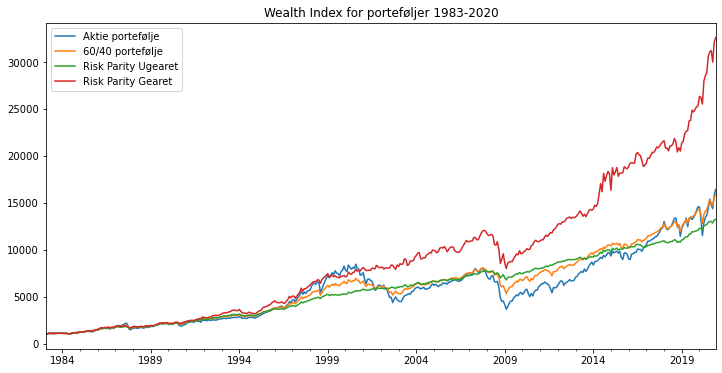

In [42]:
wi.plot(figsize=(12,6), title = 'Wealth Index for porteføljer 1983-2020')

## Portefølje statistik

In [43]:
risikofri_rente = np.array(mnd_rf['1983-02':])

In [45]:
def sharpe_ratio_rf(r, riskfree_rate, periods_per_year):
    """
    Beregner Sharpe Ratio med en timeseries for den risikofri rente
    """
    excess_ret = r.subtract(riskfree_rate, axis=0)
    ann_ex_ret = d1.annualize_rets(excess_ret, periods_per_year=12)
    ann_vol = d1.annualize_vol(r, periods_per_year=12)
    return ann_ex_ret/ann_vol

In [47]:
d1.stats(pf_afkast, risikofri_rente)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Aktie portefølje,0.076577,0.151487,0.149334,-0.568764
60/40 portefølje,0.075679,0.091990,0.237123,-0.338670
Risk Parity Ugearet,0.070478,0.053511,0.315435,-0.124188
Risk Parity Gearet,0.096258,0.101966,0.406179,-0.338753


# Korrektion af funktioner til at finde optimale RP vægte og risikobidrag

In [57]:
#-------------------- Skal sættes ind i Risk kit -----------------
from scipy.optimize import minimize
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_vol = d1.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_vol
    return risk_contrib

# Denne funktion er rettet, så den modtager parametren init_guess
def target_risk_contributions(target_risk, cov, init_guess):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    #init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

# Optimering, der sætter gæt lig forrige værdi 
def optimale_rp_vægte(afkast):
    n_aktiver = afkast.shape[1]
    optimale_rul_rp_vægte = pd.DataFrame().reindex_like(afkast)
    optimale_rul_rp_vægte.columns = ['Vægt obl.', 'Vægt akt.']
    datoer = afkast.index
    n_steps = len(datoer)
    rp_vægte = 0
    
    for step in range(n_steps):
        if step >= 60:
            cov_rul = afkast.iloc[step-60:step].cov()
            cov_år = cov_rul
            rp_vægte = target_risk_contributions(1/n_aktiver, cov_år, init_guess=optimale_rul_rp_vægte.iloc[step-1])
        else:
            optimale_rul_rp_vægte.iloc[step] = 0.5
            
        optimale_rul_rp_vægte.iloc[step] = rp_vægte      
        
    return optimale_rul_rp_vægte.iloc[60:n_steps]

In [58]:
opt_vægte = optimale_rp_vægte(mnd_afkast)

<AxesSubplot:xlabel='Date'>

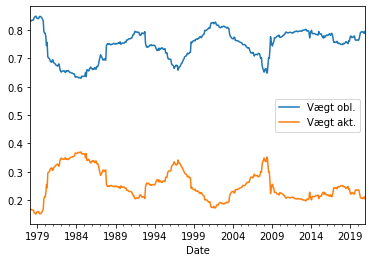

In [59]:
opt_vægte.plot()

In [76]:
# Stats for den ugearede Risk Parity portefølje
afkast_rp_u = opt_vægte.iloc[:,0] * afkast_aktiver.iloc[:,0]+opt_vægte.iloc[:,1] * afkast_aktiver.iloc[:,1]
afkast_rp_u = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_rp_u})
d1.stats(afkast_rp_u['1983-02':], mnd_rf['1983-02':]['Risikofri Rente'])

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Risk Parity Ugearet afkast,0.070641,0.05187,0.328418,-0.12419


<AxesSubplot:xlabel='Date'>

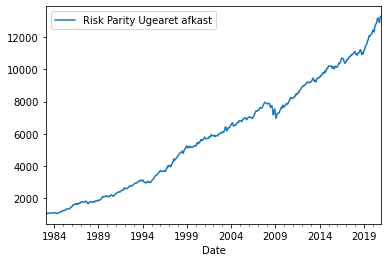

In [77]:
# Plot af Wealth Index
wi_rp_u_83 = 1000*(1+afkast_rp_u['1983-02':]).cumprod()
wi_rp_u_83.plot()

### Kovariansmatrice til beregning af risikobidrag

In [78]:
# Kovarians matrice med 5 års rullende vindue
cov_rul = mnd_afkast.rolling(60).cov()
cov_rul.index.names = ['Date', 'Aktiv']
cov_test = cov_rul.iloc[120:]

# Funktion der beregner risikobidrag

In [67]:
# Funktion der returnerer en DataFrame  -- skal sættes ind i risk kit
def r_bidrag(w, cov):
    datoer = w.index
    n_steps = len(datoer)
    risiko_b = pd.DataFrame().reindex_like(w)
    risiko_b.columns = ['RB obl.', 'RB akt.']
    rb = 0

    for step in range(n_steps):
        rb = risk_contribution(w.iloc[step].ravel(), cov.iloc[step*2:step*2+2])
        risiko_b.iloc[step] = rb.ravel()
        
    return risiko_b

In [68]:
risiko_bidrag = r_bidrag(opt_vægte, cov_test)
risiko_bidrag.head()

,RB obl.,RB akt.
Date,,
1978-02,0.499080,0.500920
1978-03,0.497944,0.502056
1978-04,0.491757,0.508243
1978-05,0.500743,0.499257
1978-06,0.501198,0.498802


<AxesSubplot:xlabel='Date'>

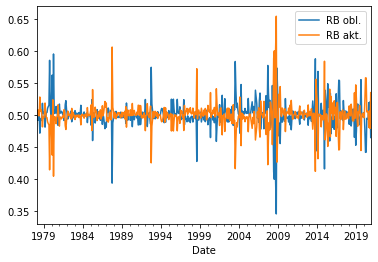

In [69]:
risiko_bidrag.plot()

# Performance under kriser - skal opdateres
Ref til https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions

OBS: Det er artiklen 'Fact and fiction about low risk investing' fra The Journal of Portfolio management' vi har brugt som udgangspunkt for periodeafgrænsning

In [53]:
# Fact and fiction perioder
p_1987_1987 = pf_afkast['1987-08':'1987-11']
p_2000_2002 = pf_afkast['2000-08':'2002-09']
p_2007_2009 = pf_afkast['2007-10':'2009-02']
p_2020_2020 = pf_afkast['2020-01':'2020-03']

In [54]:
# Beregning af akkumulerede afkast
ak_1987_1987 = (1+p_1987_1987).prod()-1
ak_2000_2002 = (1+p_2000_2002).prod()-1
ak_2007_2009 = (1+p_2007_2009).prod()-1
ak_2020_2020 = (1+p_2020_2020).prod()-1

In [55]:
tabel = pd.DataFrame({ '1987-08 til 1987-11': ak_1987_1987, '2000-08 til 2002-09': ak_2000_2002, '2007-10 til 2009-02': ak_2007_2009, '2020-01 til 2020-03': ak_2020_2020})
tabel.index.names = ['Akkumuleret afkast']
tabel

,1987-08 til 1987-11,2000-08 til 2002-09,2007-10 til 2009-02,2020-01 til 2020-03
Akkumuleret afkast,,,,
Aktie portefølje,-0.306520,-0.454601,-0.541482,-0.211071
60/40 portefølje,-0.180633,-0.225148,-0.330759,-0.100399
Risk Parity Ugearet,-0.080917,0.087047,-0.110986,0.008201
Risk Parity Gearet,-0.114877,0.095662,-0.320923,0.008609


In [56]:
mnd_afkast.to_excel('d1afkast.xlsx')